In [107]:
from google.colab import drive

drive.mount('/content/gdrive')
route = '/content/gdrive/MyDrive/CV2/Notebooks/'

print("Current directory:")
!pwd

print(f"\nWe now change the directory to '{route}'")
%cd $route
!pwd

print("\nAnd here there are our files:")
!ls -lasth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory:
/content/gdrive/My Drive/CV2/Notebooks

We now change the directory to '/content/gdrive/MyDrive/CV2/Notebooks/'
/content/gdrive/MyDrive/CV2/Notebooks
/content/gdrive/MyDrive/CV2/Notebooks

And here there are our files:
total 84M
 30M -rw------- 1 root root  30M May  9 10:18  trained-unet-augmented.pt
 30M -rw------- 1 root root  30M May  9 10:13  trained-unet.pt
1.1M -rw------- 1 root root 1.1M May  5 14:39 '3 - Image segmentation.ipynb'
 56K -rw------- 1 root root  56K Apr 26 18:32 '1a - Image classification.ipynb'
 50K -rw------- 1 root root  50K Apr 26 17:47 '1b - Image classification.ipynb'
 11M -rw------- 1 root root  11M Apr 26 17:47  trained-model.pt
132K -rw------- 1 root root 132K Apr 26 11:20 '1b - Image classification-solution.ipynb'
5.7M -rw------- 1 root root 5.7M Apr 26 11:20  trained-model-v3.pt
5.7M -rw------- 1 root root 

# Image segmentation

UNet is a convolutional network that was designed to segment biomedical images. Its success rates are high even with few images in the training set. In this notebook you will learn to implement and use an UNet for image segmentation.

Requirements:
- matplotlib
- torch
- torchvision
- glob

## The problem

Develop a methodology to segment automatically mouse embryos from microscopy images [source](https://bbbc.broadinstitute.org/BBBC003). The dataset contains 15 grayscale images with their corresponding binary masks.

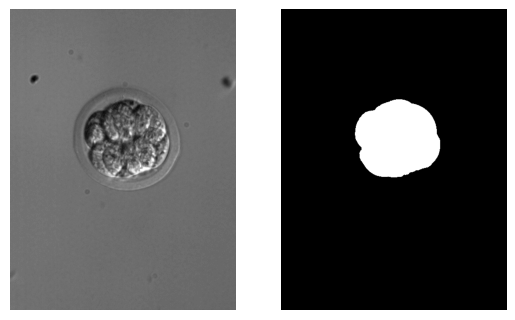

In [108]:
import matplotlib.pyplot as plt

# Aux function that shows an image and its corresponding mask in the same figure
def show(image, mask, title=None):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image, cmap="gray")
    ax[0].axis('off')
    if title is not None:
        fig.suptitle(title)
    ax[1].imshow(mask, cmap="gray")
    ax[1].axis('off')
    plt.show()
    

im = plt.imread("res/unet/images/7_19_M1E18.tif")
mask = plt.imread("res/unet/masks/7_19_M1E18.tif")
show(im,mask)




## UNet
We are going to segment the images using an UNet. To this end, we are going to follow the next steps:

1. Define the net architecture
2. Generate a training and a validation dataset
3. Train the net
4. Validate the results


First, we set where the code will be run.

In [109]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cuda


### Step 1: Model architecture

You can find online source code for the typical network architectures. In this notebook, we will use [this source code](https://github.com/usuyama/pytorch-unet).

In [110]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   


class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Step 2: Load the data

In this step, we are going to load the data by extending the torch class `Dataset`. 

Since the number of examples in our dataset is small, we can apply some transformations (rotations, traslations, blur, ...) to generate artificial samples and, this way, increase the number of samples in our dataset. This is called data augmentation. You can find more information about data augmentation and its implementation in the [pytorch documentation pages](https://pytorch.org/vision/stable/transforms.html).

In [111]:
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms
import glob
import os
import numpy as np
import random


class EmbryoDataset(Dataset):
    
    def __init__(self, image_path, mask_path, transform = None):
        super().__init__()
        # Load all the filenames with extension tif from the image_path directory
        self.img_files = glob.glob(os.path.join(image_path,'*.tif'))
        self.mask_files = []
        # We asume that each image has the same filename as its corresponding mask
        # but it is stored in another directory (mask_path)
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(mask_path,os.path.basename(img_path)))
                
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = plt.imread(img_path)
            mask = plt.imread(mask_path)
            if len(mask.shape) > 2:
                # Some tiff images in this dataset has 4 identical channels :S
                mask = mask[:,:,0]
            
            # Apply the defined transformations to both image and mask
            if self.transform is not None:
                seed = np.random.randint(2147483647) # make a seed with numpy generator 
                random.seed(seed) # apply this seed to image transforms
                torch.manual_seed(seed) 
                image = self.transform(image)
                random.seed(seed) # apply the same seed to mask transforms
                torch.manual_seed(seed) 
                mask = self.transform(mask)
            else:
                t2 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.ToTensor()])
                image = t2(image)
                mask = t2(mask)
                
                
            return image, mask

    def __len__(self):
        return len(self.img_files)


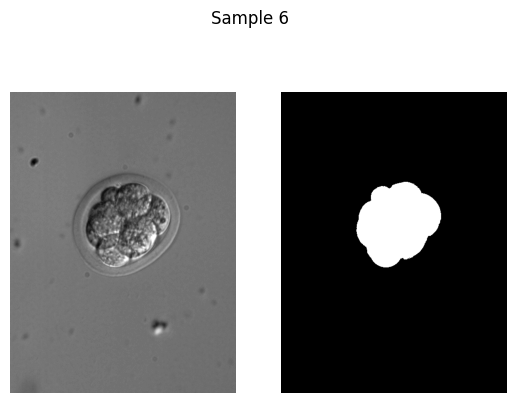

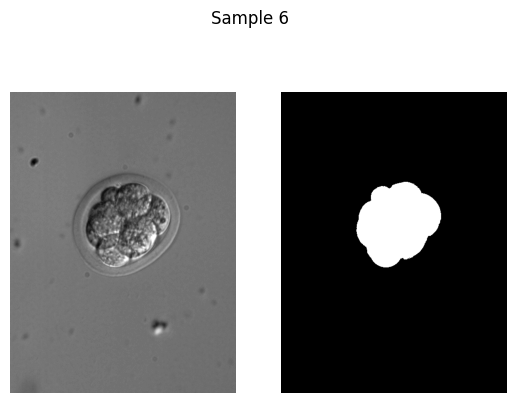

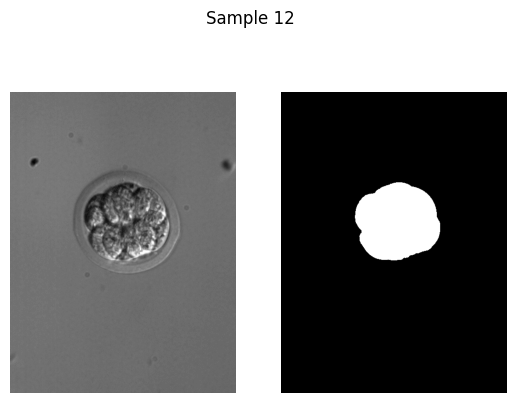

In [112]:
# Load some samples
simple_dataset = EmbryoDataset("res/unet/images", "res/unet/masks")
nsamples = 3
for _ in range(nsamples):
    idx = np.random.randint(0, len(simple_dataset))
    im, mask = simple_dataset[idx]
    show(im.squeeze(), mask.squeeze(), title=f"Sample {idx}")
    
# Divide the dataset into training and validation datasets
train_dataset, valid_dataset = torch.utils.data.random_split(simple_dataset, [12, 3])

## Step 3: Training

Once the training and validation datasets are created, the next step is training.

In [113]:
# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
#THRESHOLD = 0.2
EPOCHS = 50

# Model
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)


# Loss function
bce_loss = nn.BCEWithLogitsLoss()

# Optimizer
adam_optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

#### Exercise
Use the training function that you have implemented in the notebook 1b to train the UNet. Compute the accuracy as the IoU between the segmentation mask and the prediction. 
Feed the net with the original dataset without data augmentation and check the results.

**Hint**: In order to compute the IoU, the function `get_segmentation_masks` can be used to compute a segmentation mask from the outputs of the net. The output of the net is a positive floating point value. The sigmoid function restricts the output domain between 0 and 1. Since the output mask is binary, we use a threshold to set the output mask values to 0 or 1. Note that maybe you should tweak the default threshold.

In [114]:
def get_segmentation_masks(outputs, threshold):
    probs = torch.sigmoid(outputs)
    masks = (probs>threshold)*1.0
    return masks

In [115]:
def compute_iou(outputs, targets, threshold=0.15):
    predicted_masks = get_segmentation_masks(outputs, threshold)
    intersection = torch.logical_and(predicted_masks, targets).sum(dim=(2, 3))
    union = torch.logical_or(predicted_masks, targets).sum(dim=(2, 3))
    iou = (intersection.float() / union.float() + 1e-6).mean()
    return iou.item()

In [116]:


def train_model(model, train_dataset, valid_dataset, device, optimizer, loss, batch_size, num_epochs, output_filename='trained-unet.pt'):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    
    best_iou = 0.0
    best_loss = 1000000
    iou_evolution = []  # List to store IoU values at each epoch
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss_value = loss(outputs, targets)
            train_loss += loss_value.item()
            
            iou = compute_iou(outputs, targets)
            train_iou += iou
            
            loss_value.backward()
            optimizer.step()
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        
        iou_evolution.append(train_iou)  # Add current IoU to the evolution list
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - IoU: {train_iou:.4f}")
    
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), output_filename)

    
    print("Training completed.")
    
    return iou_evolution  # Return the IoU evolution list


In [117]:
train_model(unet, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, f'{route}/trained-unet.pt')

Epoch [1/50] - Loss: 0.7181 - IoU: 0.0843
Epoch [2/50] - Loss: 0.6950 - IoU: 0.0843
Epoch [3/50] - Loss: 0.5563 - IoU: 0.0843
Epoch [4/50] - Loss: 0.3481 - IoU: 0.0000
Epoch [5/50] - Loss: 0.3335 - IoU: 0.0636
Epoch [6/50] - Loss: 0.3107 - IoU: 0.0000
Epoch [7/50] - Loss: 0.3052 - IoU: 0.0128
Epoch [8/50] - Loss: 0.3018 - IoU: 0.0000
Epoch [9/50] - Loss: 0.2980 - IoU: 0.0000
Epoch [10/50] - Loss: 0.2932 - IoU: 0.0000
Epoch [11/50] - Loss: 0.2891 - IoU: 0.0000
Epoch [12/50] - Loss: 0.2830 - IoU: 0.0000
Epoch [13/50] - Loss: 0.2763 - IoU: 0.0000
Epoch [14/50] - Loss: 0.2701 - IoU: 0.0000
Epoch [15/50] - Loss: 0.2657 - IoU: 0.0124
Epoch [16/50] - Loss: 0.2616 - IoU: 0.0061
Epoch [17/50] - Loss: 0.2560 - IoU: 0.0524
Epoch [18/50] - Loss: 0.2494 - IoU: 0.1309
Epoch [19/50] - Loss: 0.2373 - IoU: 0.3597
Epoch [20/50] - Loss: 0.2146 - IoU: 0.4751
Epoch [21/50] - Loss: 0.1577 - IoU: 0.6949
Epoch [22/50] - Loss: 0.1305 - IoU: 0.7119
Epoch [23/50] - Loss: 0.2022 - IoU: 0.4543
Epoch [24/50] - Loss

[0.08429597318172455,
 0.08429597442348798,
 0.08429597566525142,
 9.999999974752427e-07,
 0.06362528629318831,
 9.999999974752427e-07,
 0.012827906938108905,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 0.01244908896698386,
 0.006073580428846981,
 0.05240950341237749,
 0.13087457220408774,
 0.3596747233144318,
 0.4750730339437723,
 0.6948912044366201,
 0.7119039843479792,
 0.4542829444011052,
 0.5812533795833588,
 0.664687712987264,
 0.7625996867815653,
 0.8292269309361776,
 0.8602667649586996,
 0.8239279488722483,
 0.8676456908384959,
 0.8623538116614023,
 0.8670891026655833,
 0.8742978076140085,
 0.8888426919778188,
 0.8736392358938853,
 0.8988630771636963,
 0.87688281138738,
 0.8918969829877218,
 0.8993787467479706,
 0.8781881630420685,
 0.8516072630882263,
 0.8555092215538025,
 0.8588782449563345,
 0.8526461025079092,
 0.8659967084725698,
 0.8681178192297617,

### Step 4: Validate the results

After training we can check the results in the dataset.

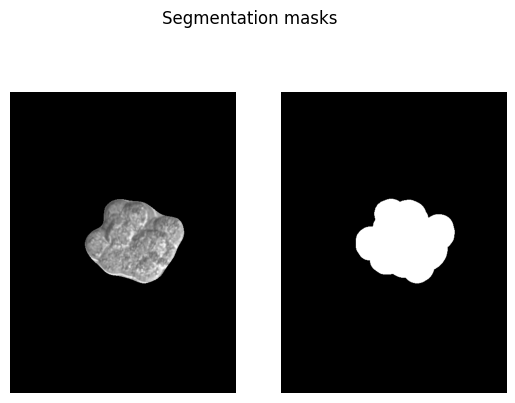

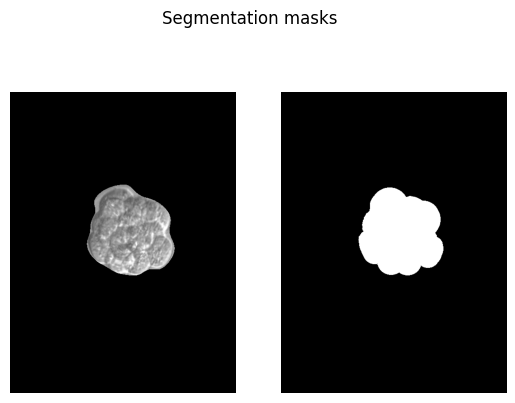

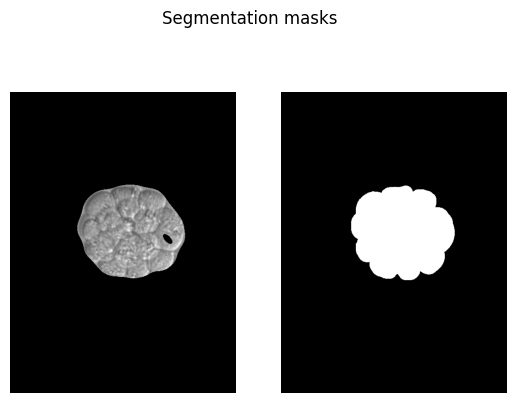

In [118]:
def check_segmentation_results(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title="Segmentation masks")

    
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)
unet.load_state_dict(torch.load(f'{route}/trained-unet.pt'))
#unet = torch.load(f'{route}/trained-unet.pt', map_location=device)


check_segmentation_results(unet, valid_dataset, 0.3)

#### Exercise
Modify the function `check_segmentation_results` to include the IoU metric.

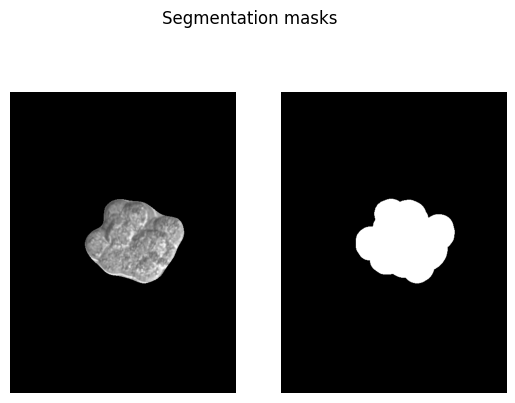

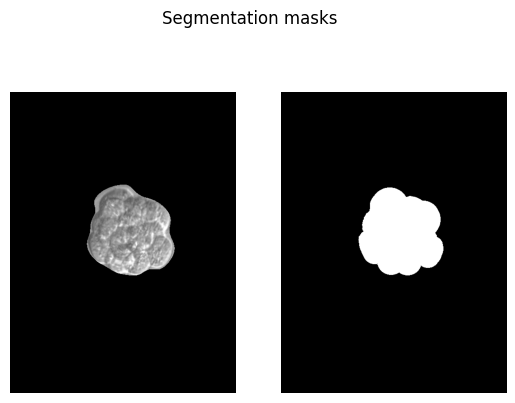

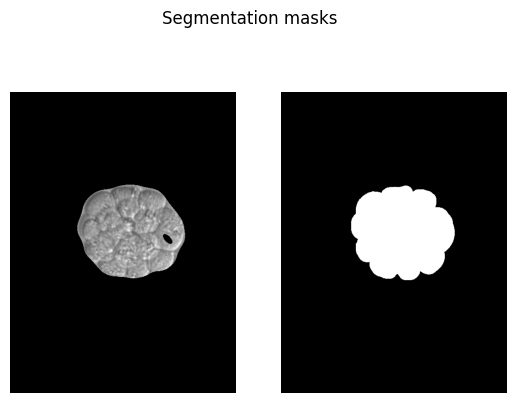

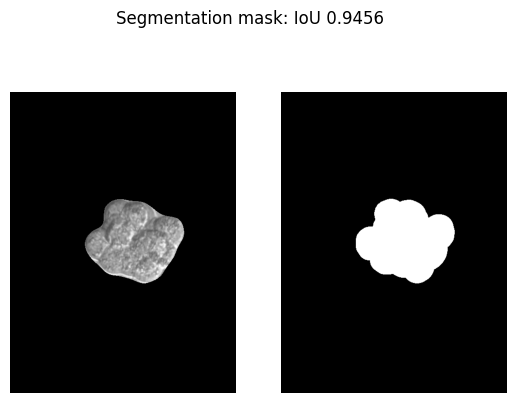

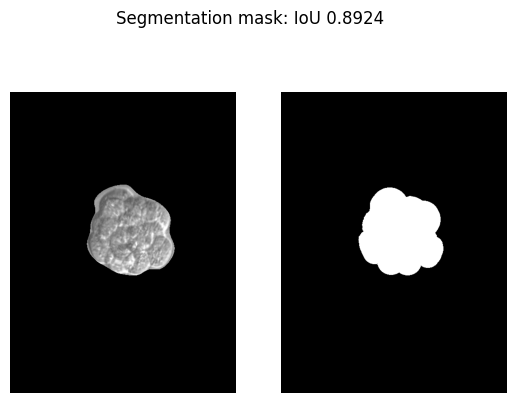

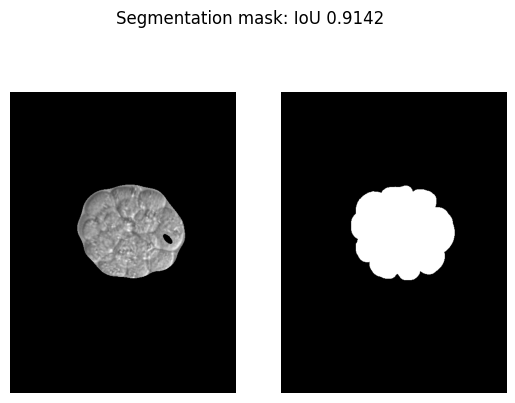

In [119]:
def check_segmentation_results_with_acc(model, dataset, threshold=0.5):
    model.eval()
    for image, mask in dataset:
        image = image[None, :,:,:]
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)
        predicted_mask = get_segmentation_masks(output, threshold)
        # Write your code here
        #iou = 0
        iou = compute_iou(output, mask)
        show(image.cpu().squeeze()*predicted_mask.cpu().squeeze(), mask.cpu().squeeze(), title=f"Segmentation mask: IoU {iou:.4f}")

    
unet = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet.to(device)
unet.load_state_dict(torch.load(f'{route}/trained-unet.pt'))


check_segmentation_results(unet, valid_dataset, 0.3)

check_segmentation_results_with_acc(unet, valid_dataset, 0.3)

### Exercise

Define a set of suitable transforms, train the UNet with data augmentation and check the results.

In [120]:
# Load images with data augmentation
transf = transforms.Compose([
        transforms.ToPILImage(),
        # Define your transformations here!
        
        transforms.ToTensor()
    ])


augmented_dataset = EmbryoDataset("res/unet/images", "res/unet/masks", transf)

train_dataset, valid_dataset = torch.utils.data.random_split(augmented_dataset, [12, 3])

# Hyperparameters
BATCH_SIZE = 2
LR = 0.0001
N_INPUT_CHANNELS = 1
N_CLASSES = 1
THRESHOLD = 0.5
EPOCHS = 50


# Model
unet_augmented = UNet(N_INPUT_CHANNELS,N_CLASSES)
unet_augmented.to(device)

adam_optimizer = torch.optim.Adam(unet_augmented.parameters(), lr=LR)

train_model(unet_augmented, train_dataset, valid_dataset, device, adam_optimizer, bce_loss, BATCH_SIZE, EPOCHS, f'{route}/trained-unet-augmented.pt')



Epoch [1/50] - Loss: 0.6492 - IoU: 0.0833
Epoch [2/50] - Loss: 0.6209 - IoU: 0.0833
Epoch [3/50] - Loss: 0.4212 - IoU: 0.0567
Epoch [4/50] - Loss: 0.3318 - IoU: 0.0341
Epoch [5/50] - Loss: 0.3158 - IoU: 0.0335
Epoch [6/50] - Loss: 0.3045 - IoU: 0.0000
Epoch [7/50] - Loss: 0.2981 - IoU: 0.0000
Epoch [8/50] - Loss: 0.2952 - IoU: 0.0000
Epoch [9/50] - Loss: 0.2920 - IoU: 0.0000
Epoch [10/50] - Loss: 0.2874 - IoU: 0.0000
Epoch [11/50] - Loss: 0.2825 - IoU: 0.0000
Epoch [12/50] - Loss: 0.2760 - IoU: 0.0000
Epoch [13/50] - Loss: 0.2677 - IoU: 0.0000
Epoch [14/50] - Loss: 0.2619 - IoU: 0.0000
Epoch [15/50] - Loss: 0.2546 - IoU: 0.0000
Epoch [16/50] - Loss: 0.2402 - IoU: 0.1481
Epoch [17/50] - Loss: 0.2001 - IoU: 0.6565
Epoch [18/50] - Loss: 0.1704 - IoU: 0.5979
Epoch [19/50] - Loss: 0.1411 - IoU: 0.7189
Epoch [20/50] - Loss: 0.1470 - IoU: 0.6525
Epoch [21/50] - Loss: 0.1268 - IoU: 0.7189
Epoch [22/50] - Loss: 0.0950 - IoU: 0.8421
Epoch [23/50] - Loss: 0.0868 - IoU: 0.8632
Epoch [24/50] - Loss

[0.08329147224624951,
 0.08329147348801295,
 0.05671459490489875,
 0.034100266634065214,
 0.033529864814359676,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 9.999999974752427e-07,
 0.1481412041791259,
 0.6564901548347469,
 0.5978878984848658,
 0.7188932995001475,
 0.6525091404716173,
 0.7189201414585114,
 0.842069019873937,
 0.8631549576918284,
 0.9071996510028839,
 0.8584918081760406,
 0.8665073911348978,
 0.9012513955434164,
 0.8780727386474609,
 0.8872632483641306,
 0.9071672658125559,
 0.9007605810960134,
 0.8977647622426351,
 0.9190658032894135,
 0.9247146745522817,
 0.9098322490851084,
 0.91960009932518,
 0.9017758270104727,
 0.8851467172304789,
 0.8961138725280762,
 0.9108605782190958,
 0.924019436041514,
 0.9249570369720459,
 0.9164237082004547,
 0.9206806123256683,
 0.9221022427082062,
 0.9215872685114542,
 

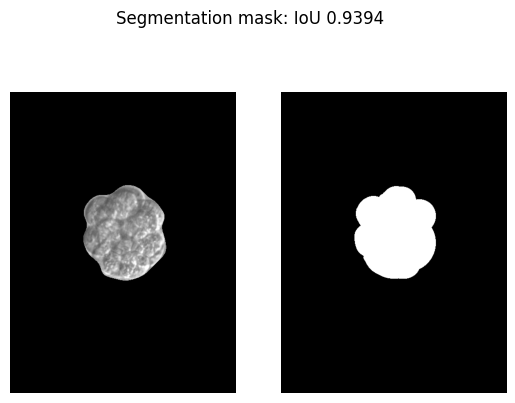

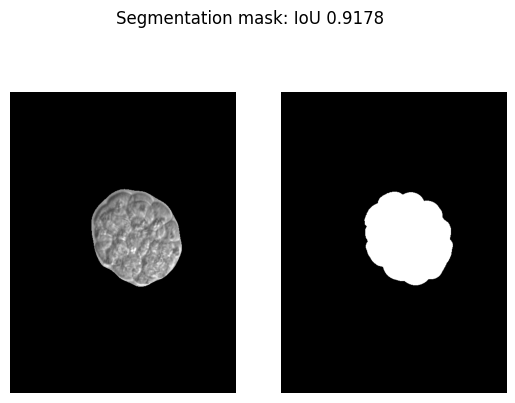

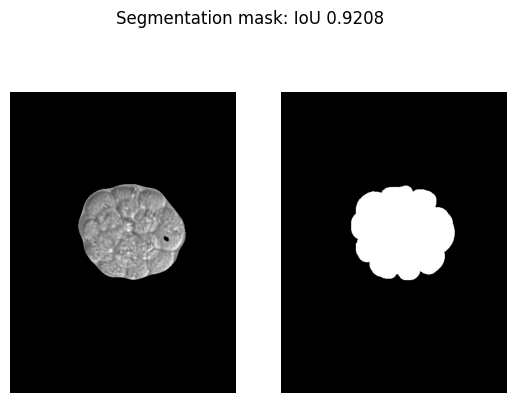

In [121]:
unet = torch.load(f'{route}/trained-unet-augmented.pt', map_location=device)

check_segmentation_results_with_acc(unet_augmented, valid_dataset, 0.3)